## 3D molecules in cells

This tutorial uses napari 0.4.12.<br>

Dataset :<br>
scikit-image > Cells (3D+2Ch)

Analysis goals:<br> 
Count the number of points per cell.

Tutorial goals:<br>
(1) Use napari + Python libraries to perform common image analysis from end to end.<br>
(2) Note napari viewer GUI/API function availability at various steps.  

Steps:
- Load image
- Cell segmentation
- Points detection
- Quantify number of points per cell
- Plot number of points versus cell size

<font color=red> RED: links to add<br> </font>
<font color=blue> BLUE: GUI availability in viewer </font>

## Load Image

Use skimage.data.cells3d as the example image.<br>
The original image has dimension ZCYT=(60, 2, 256, 256). Load each channel as an image layer for easier display and downstream process.


In [1]:
import napari
from napari.utils import nbscreenshot
from skimage import data

print("file dimension: (z,ch,y,x)", data.cells3d().shape)

file dimension: (z,ch,y,x) (60, 2, 256, 256)


In [2]:
#load multichannel image in one line, with additional options
viewer = napari.view_image(data.cells3d(), channel_axis=1, name=["membrane", "nuclei"], colormap=["green", "magenta"])
viewer.dims.ndisplay = 3

## Cell segmentation

Use Cellpose to segment cells, with following settings for faster calculation:<br>
image layer = nuclei<br>
model type = nuclei<br>
click "compute diameter from image"<br>
uncheck "average 4 nets", "output flows and cellprob", "output outlines", "resample dynamics"<br>
check "process stack as 3D"<br>

Once done, use label eraser to manually clean up unwanted fragments from dividing nucleus.<br>
Note: label eraser - can work in 3D display but not quite clear why sometimes specific pixels are not being picked up.<br>
Note: Cellpose can segment this image quite well, but takes minutes to finish calculation on a 2019 Macbook Pro. <br>

<font color=red> labels layer, Cellpose doc </font><br>
<font color=blue> Cellpose plugin, label manual editing tool </font>


In [3]:
#Once done, save the label layer for convinience 
file_name = '/Users/cchiu/Desktop/images/tutorial_test.tif'
#viewer.layers[2].save(file_name)

In [10]:
#Reload the saved label layer if necessary
from tifffile import imread
viewer.add_labels(imread(file_name), name = 'seg')

<Labels layer 'seg' at 0x177fbccd0>

In [ ]:
nbscreenshot(viewer)

## Points detection

(1) Use skimage.feature.blob_log to detect points in membrane channel <br>
(2) Add points layer named "aggregates" <br>

<font color=red> points layer </font><br>
<font color=blue> napari-segment-blobs-and-things-with-membranes plugin </font>

In [11]:
from skimage.feature import blob_log

blobs = blob_log(viewer.layers['membrane'].data, min_sigma=0.35, max_sigma=1, num_sigma=10, threshold=0.6)

#returns coordinates + sigma, only keep coordinates
points = blobs[:,:-1]
print("total points detected:", points.shape[0])

viewer.add_points(points, size=2, name='aggregates')

total points detected: 341


<Points layer 'aggregates' at 0x1cfe72eb0>

## Quantify number of points per cell

Use label layer value to identify points location.<br>

In [10]:
import pandas as pd

cells = viewer.layers['seg'].data

#create a dataframe that contains points and their corresponding cell location
agg_cell = pd.DataFrame(columns=['z', 'y', 'x','cell'])
for agg in viewer.layers['aggregates'].data:
    z,y,x = agg.astype(int)
    agg_cell = agg_cell.append({'z':z,'y':y,'x':x,'cell':cells[z,y,x]},ignore_index=True) 

agg_count = agg_cell['cell'].value_counts().to_frame()
agg_count = agg_count.reset_index().rename(columns={'index':'cell','cell':'pt_count'})
print(agg_count)

    cell  pt_count
0      0       311
1     34         4
2     20         4
3     37         4
4     42         3
5     12         2
6     28         2
7     15         2
8     23         2
9     43         2
10    26         2
11    18         1
12    27         1
13    30         1


## Plot number of points versus cell size

<AxesSubplot:xlabel='size', ylabel='pt_count'>

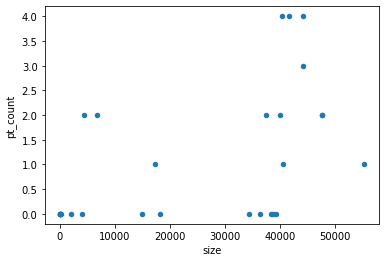

In [12]:
import numpy as np
from skimage.measure import regionprops_table

properties = ['label', 'area']

cell_table = pd.DataFrame(regionprops_table(cells, properties=properties))
cell_table = cell_table.rename(columns={"label": "cell", "area": "size"})

#combine agg_count and cell_table
#columns: cell, pt_count, size
result = pd.merge(agg_count, cell_table, how="right", on=["cell"]).fillna(0)

#scatter plot: number of points versus cell size
import matplotlib.pyplot as plt
result.plot.scatter(x="size", y="pt_count")